In [1]:
import os

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import ModelCheckpoint
from rich import print
from sklearn.datasets import fetch_20newsgroups
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer

L.seed_everything(42)

%load_ext rich

DATA_DIR = os.path.join(os.getcwd(), "data")

c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


In [2]:
# --- MODEL HYPERPARAMETERS ---
BATCH_SIZE = 16
MAX_LENGTH = 512

LEARNING_RATE = 1e-5

N_EMBED = 768
N_HEADS = 2
N_BLOCKS = 12
DROPOUT = 0.2
NUM_LABELS = 20

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load and preprocess data

In [3]:
train = fetch_20newsgroups(data_home=DATA_DIR, subset="train")
test = fetch_20newsgroups(data_home=DATA_DIR, subset="test")


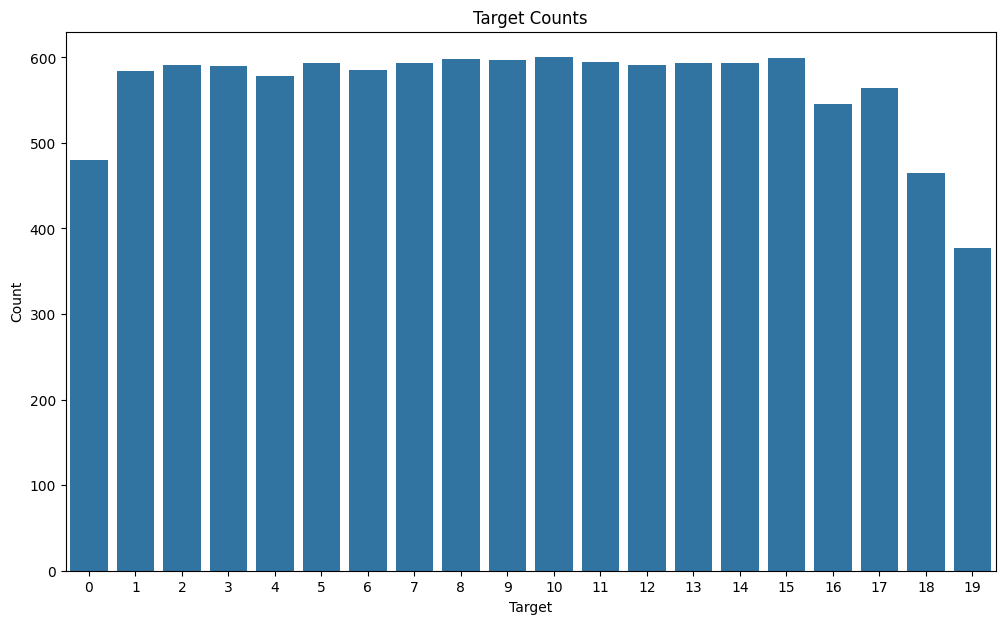

In [4]:
plt.figure(figsize=(12, 7))
sns.countplot(x=train.target)
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [5]:
len(train.data), len(test.data)

(11314, 7532)

### Tokenizer

Next, we load the tokenizer used for `gpt2-small` using HuggingFace Transformers library. Since we plan to finetune the model on our dataset, we will add padding to our data and provide a maximum length, as transformers process inputs all at once. However, to prevent the model from overfitting the attention on these padding tokens, we will also provide an attention mask to the model.

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


In [7]:
class TextDataset(Dataset):
    def __init__(self, data, target):
        self.texts = [text for text in data]

        self.labels = target

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return tokenizer(
            self.texts[idx],
            padding="max_length",
            max_length=MAX_LENGTH,
            truncation=True,
            return_tensors="pt",
        )

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [8]:
train_idx, val_idx = np.split(
    np.random.permutation(len(train.data)), [int(0.8 * len(train.data))]
)

train_dataset = TextDataset([train.data[i] for i in train_idx], train.target[train_idx])
val_dataset = TextDataset([train.data[i] for i in val_idx], train.target[val_idx])
test_dataset = TextDataset(test.data, test.target)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
len(train_loader), len(val_loader), len(test_loader)

(566, 142, 471)

## Build the self-attention mechanism

### Attention layer

In [10]:
class AttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(N_EMBED, head_size, bias=False)
        self.key = nn.Linear(N_EMBED, head_size, bias=False)
        self.value = nn.Linear(N_EMBED, head_size, bias=False)

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        weights = q @ k.transpose(-2, -1) * (C**-0.5)

        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        out = weights @ v
        return out

### Multi-head attention

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(N_EMBED, N_EMBED)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out


### Projection layer

In [12]:
class FeedForward(nn.Module):
    def __init__(self, n_embed, scale_factor=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, scale_factor * n_embed),
            nn.GELU(),
            nn.Linear(scale_factor * n_embed, n_embed),  # Projection layer
            nn.Dropout(DROPOUT),
        )

    def forward(self, x):
        return self.net(x)


### Bundling into a Transformer block

In [13]:
class Block(nn.Module):
    def __init__(self, n_embed, n_heads):
        super().__init__()
        self.sa_heads = MultiHeadAttention(n_heads, n_embed // n_heads)
        self.ln1 = nn.LayerNorm(n_embed)

        self.ffwd = FeedForward(n_embed, 4)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa_heads(self.ln1(x))  # Residual connection + attention
        x = x + self.ffwd(self.ln2(x))  # Residual connection + feed-forward
        return x

In [14]:
MultiHeadAttention(768 // 64, 64)(torch.randn(1, 512, 768)).shape

torch.Size([1, 512, 768])

In [15]:
Block(768, 6)(torch.randn(1, 512, 768)).shape

torch.Size([1, 512, 768])

### The classifier model

In [16]:
class GPT2Classifer(nn.Module):
    def __init__(self, hidden_size, num_classes, max_seq_len, n_heads, n_layers=3):
        super().__init__()

        self.gpt2config = GPT2Config.from_pretrained("gpt2", n_layer=n_layers)
        self.gpt2 = GPT2Model.from_pretrained("gpt2", config=self.gpt2config)

        self.tf_block = Block(hidden_size, n_heads)
        self.classifier = nn.Linear(hidden_size * max_seq_len, num_classes)

    def forward(self, input_ids, attention_mask):
        gpt_out = self.gpt2(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=True
        ).last_hidden_state

        # Pass through transformer block
        gpt_out = self.tf_block(gpt_out)

        # Flatten and pass through classifier layer
        logits = self.classifier(gpt_out.view(gpt_out.size(0), -1))
        return logits

In [17]:
model = GPT2Classifer(N_EMBED, NUM_LABELS, MAX_LENGTH, N_HEADS, n_layers=4).to(device)

with torch.no_grad():
    out = model(
        train_dataset.get_batch_texts(0)["input_ids"].squeeze(1).to(device),
        train_dataset.get_batch_texts(0)["attention_mask"].to(device),
    )

    print(out.shape)

torch.Size([1, 20])

## Training the model

In [18]:
class TransformerClassifier(L.LightningModule):
    def __init__(
        self, hidden_size, num_classes, max_seq_len, n_heads, n_layers, lr=1e-5
    ):
        super().__init__()

        self.model = GPT2Classifer(
            hidden_size, num_classes, max_seq_len, n_heads, n_layers
        )
        self.lr = lr

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        x, y = batch
        input_ids = x["input_ids"].squeeze(1).to(device)
        attention_mask = x["attention_mask"].to(device)
        y = y.to(device).long()

        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, y)

        acc = (logits.argmax(1) == y).float().mean()

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        input_ids = x["input_ids"].squeeze(1).to(device)
        attention_mask = x["attention_mask"].to(device)
        y = y.to(device).long()

        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, y)

        acc = (logits.argmax(1) == y).float().mean()

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        if batch_idx == 0:
            r_idx = np.random.randint(0, len(y))  # Random index

            print(
                f"Input: {tokenizer.decode(input_ids[r_idx], skip_special_tokens=True)}"
            )
            print(f"Label: {y[r_idx]}")
            print(f"Prediction: {logits.argmax(1)[r_idx]}")

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        input_ids = x["input_ids"].squeeze(1).to(device)
        attention_mask = x["attention_mask"].to(device)
        y = y.to(device).long()

        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, y)

        acc = (logits.argmax(1) == y).float().mean()

        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [19]:
model = TransformerClassifier(
    N_EMBED, NUM_LABELS, MAX_LENGTH, N_HEADS, N_BLOCKS, lr=LEARNING_RATE
).to(device)

model



TransformerClassifier(
  (model): GPT2Classifer(
    (gpt2): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (tf_block): Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 

In [20]:
trainer = L.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
    callbacks=[ModelCheckpoint(monitor="val_acc", mode="max")],
)

trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, train_loader, val_loader)

2024-05-30 18:01:15.215680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 18:01:15.215817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 18:01:15.351876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type          | Params
----------------------------------------
0 | model | GPT2Classifer | 139 M 
----------------------------------------
139 M     Trainable params
0         Non-trainable params
139 M     Total params
557.559   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Input: From: i3y092@rick.cs.ubc.ca (Adam Nicolas Cheal)
Subject: Jumper Settings for MicroScience HD
Organization: Computer Science, University of B.C., Vancouver, B.C., Canada
Lines: 9
Distribution: world
NNTP-Posting-Host: bowen.rick.cs.ubc.ca

OK, I'll try one more time with this one. If ANYONE out there has ANY
information on MicroScience hard drives and how to set the jumpers
(and where they are?) for master/slave configurations. I will gladly
accept any info, as I have a 110M'er sitting in my room collecting dust
just waiting for me to install huge applications. :) Thanks in advance.
(And yes, I regulary check the IDE Harddisk Spec that is posted here.)

-= Adam Cheal =-   i3y092@rick.cs.ubc.ca

Label: 3

Prediction: 18

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Input: From: i3y092@rick.cs.ubc.ca (Adam Nicolas Cheal)
Subject: Jumper Settings for MicroScience HD
Organization: Computer Science, University of B.C., Vancouver, B.C., Canada
Lines: 9
Distribution: world
NNTP-Posting-Host: bowen.rick.cs.ubc.ca

OK, I'll try one more time with this one. If ANYONE out there has ANY
information on MicroScience hard drives and how to set the jumpers
(and where they are?) for master/slave configurations. I will gladly
accept any info, as I have a 110M'er sitting in my room collecting dust
just waiting for me to install huge applications. :) Thanks in advance.
(And yes, I regulary check the IDE Harddisk Spec that is posted here.)

-= Adam Cheal =-   i3y092@rick.cs.ubc.ca

Label: 3

Prediction: 4

Validation: |          | 0/? [00:00<?, ?it/s]

Input: From: yamauchi@ces.cwru.edu (Brian Yamauchi)
Subject: DC-X: Choice of a New Generation (was Re: SSRT Roll-Out Speech)
Organization: Case Western Reserve University
Lines: 27
Distribution: world
NNTP-Posting-Host: yuggoth.ces.cwru.edu
In-reply-to: jkatz@access.digex.com's message of 21 Apr 1993 22:09:32 -0400

In article <1r4uos$jid@access.digex.net> jkatz@access.digex.com (Jordan Katz) writes:

>                  Speech Delivered by Col. Simon P. Worden,
>                       The Deputy for Technology, SDIO
>
>       Most of you, as am I, are "children of the 1960's."  We grew
>up in an age of miracles -- Inter-Continental Ballistic Missiles,
>nuclear energy, computers, flights to the moon.  But these were
>miracles of our parent's doing. 

>                          Speech by Pete Worden
>          Delivered Before the U.S. Space Foundation Conference

>     I'm embarrassed when my generation is compared with the last
>generation -- the giants of the last great space era, the 1950's
>and 1960's.  They went to the moon - we built a telescope that
>can't see straight.  They soft-landed on Mars - the least we
>could do is soft-land on Earth!

Just out of curiousity, how old is Worden?
--
_______________________________________________________________________________

Brian Yamauchi                  Case Western Reserve University
yamauchi@alpha.ces.cwru.edu     Department of Computer Engineering and Science
_______________________________________________________________________________

Label: 14

Prediction: 14

Validation: |          | 0/? [00:00<?, ?it/s]

Input: From: tsa@cellar.org (The Silent Assassin)
Subject: Wanted:  286 motherboard, VGA card
Organization: The Cellar BBS and public access system
Lines: 9

I am looking for a 286 motherboard, preferable 12 or 16, 640k or 1 meg RAM. 
I am also looking for a VGA card.

Am willing to trade 1200 external, 5.25" LD Drive, 8088 motherboard,
monochrome monitor, Game Boy, in some combination for the above.

Libertarian, atheist, semi-anarchal Techno-Rat.

I define myself--tsa@cellar.org

Label: 6

Prediction: 6

Validation: |          | 0/? [00:00<?, ?it/s]

Input: From: jbrown@batman.bmd.trw.com
Subject: Re: Gulf War and Peace-niks
Lines: 67

In article <1993Apr20.062328.19776@bmerh85.bnr.ca>, 
dgraham@bmers30.bnr.ca (Douglas Graham) writes:

[...]
> 
> Wait a minute.  You said *never* play a Chamberlain.  Since the US
> *is* playing Chamberlain as far as East Timor is concerned, wouldn't
> that lead you to think that your argument is irrelevant and had nothing
> to do with the Gulf War?  Actually, I rather like your idea.  Perhaps
> the rest of the world should have bombed (or maybe missiled) Washington
> when the US invaded Nicaragua, Grenada, Panama, Vietnam, Mexico, Hawaii,
> or any number of other places.

Wait a minute, Doug.  I know you are better informed than that.  The US 
has never invaded Nicaragua (as far as I know).  We liberated Grenada 
from the Cubans to protect US citizens there and to prevent the completion 
of a strategic air strip.  Panama we invaded, true (twice this century).  
Vietnam?  We were invited in by the government of S. Vietnam.  (I guess 
we "invaded" Saudi Arabia during the Gulf War, eh?)  Mexico?  We have 
invaded Mexico 2 or 3 times, once this century, but there were no missiles 
for anyone to shoot over here at that time.  Hawaii?  We liberated it from 
Spain.

So if you mean by the word "invaded" some sort of military action where
we cross someone's border, you are right 5 out of 6.  But normally
"invaded" carries a connotation of attacking an autonomous nation.
(If some nation "invades" the U.S. Virgin Islands, would they be
invading the Virgin Islands or the U.S.?)  So from this point of
view, your score falls to 2 out of 6 (Mexico, Panama).

[...]
> 
> What's a "peace-nik"?  Is that somebody who *doesn't* masturbate
> over "Guns'n

Label: 0

Prediction: 18

Validation: |          | 0/? [00:00<?, ?it/s]

Input: From: Dave Dal Farra <gpz750@bnr.ca>
Subject: Re: Eating and Riding was Re: Drinking and Riding
X-Xxdate: Tue, 6 Apr 93 15:22:03 GMT
Nntp-Posting-Host: bcarm41a
Organization: BNR Ltd.
X-Useragent: Nuntius v1.1.1d9
Lines: 30

In article <PNAKADA.93Apr5140811@pnakada.oracle.com> Paul Nakada,
pnakada@oracle.com writes:
>
>What's the feeling about eating and riding?  I went out riding this
>weekend, and got a little carried away with some pecan pie.  The whole
>ride back I felt sluggish.  I was certainly much more alert on the
>ride in.  I'm sure others have the same feeling, but the strangest
>thing is that eating is usually the turnaround point of weekend rides.
>
>From now on, a little snack will do.  I'd much rather have a get that
>full/sluggish feeling closer to home.
>
>-Paul
>--
>Paul Nakada | Oracle Corporation | pnakada@oracle.com
>DoD #7773 | '91 R100C | '90 K75S
>

To maintain my senses at their sharpest, I never eat a full meal
within 24 hrs of a ride.   I've tried Slim Fast Lite before a 
ride but found that my lap times around the Parliament Buildings suffered 
0.1 secs.   The resultant 70 pound weight loss over the summer
just sharpens my bike's handling and I can always look
forward to a winter of carbo-loading.

Obligatory 8:)

Dave D.F.
"It's true they say that money talks.  When mine spoke it said
'Buy me a Drink!'."

Label: 8

Prediction: 8

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.


## Evaluate and predict on test set

In [21]:
model = TransformerClassifier(
    N_EMBED, NUM_LABELS, MAX_LENGTH, N_HEADS, N_BLOCKS, lr=LEARNING_RATE
).to(device)

state_dict = torch.load("./model/gpt2_classifier_model_mgsc695_a3.ckpt")
model.load_state_dict(state_dict["state_dict"])
model


TransformerClassifier(
  (model): GPT2Classifer(
    (gpt2): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (tf_block): Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 

In [25]:
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.7808018922805786     │
│      test_loss_epoch      │    0.9667865633964539     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.9667865633964539, 'test_acc_epoch': 0.7808018922805786}]

In [22]:
X, y = next(iter(test_loader))

In [50]:
logits = model(X["input_ids"][1].to(device), X["attention_mask"][1].to(device))

print(tokenizer.decode(X["input_ids"][1][0], skip_special_tokens=True))
print(f"Actual Label: {y[1]}")
print(f"Predicted Label: {logits.argmax(1).item()}")


From: Rick Miller <rick@ee.uwm.edu>
Subject: X-Face?
Organization: Just me.
Lines: 17
Distribution: world
NNTP-Posting-Host: 129.89.2.33
Summary: Go ahead... swamp me.  <EEP!>

I'm not familiar at all with the format of these "X-Face:" thingies, but
after seeing them in some folks' headers, I've *got* to *see* them (and
maybe make one of my own)!

I've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")
and I've managed to compile compface too... but now that I'm *looking*
for them, I can't seem to find any X-Face:'s in anyones news headers!  :-(

Could you, would you, please send me your "X-Face:" header?

I *know* I'll probably get a little swamped, but I can handle it.

        ...I hope.

Rick Miller  <rick@ee.uwm.edu> | <ricxjo@discus.mil.wi.us>   Ricxjo Muelisto
Send a postcard, get one back! | Enposxtigu bildkarton kaj vi ricevos alion!
          RICK MILLER // 16203 WOODS // MUSKEGO, WIS. 53150 // USA

Actual Label: 5

Predicted Label: 5